In [47]:
import os, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import time
plt.rcParams['figure.figsize'] = [25, 15]
plt.rcParams.update({'font.size': 25})

In [2]:
def load_dataframe_from_files(dirin, fileprefix, max_files=100):
    import glob
    files = glob.glob(os.path.join(dirin, fileprefix))
    print("[Info] Loading {} files wt prefix:\n{}".format(len(files), fileprefix))
    df = pd.read_csv(files[0], comment='#', index_col=False)
    for file in files[1:max_files]:
        print(".", end='')
        dftmp = pd.read_csv(file, comment='#', index_col=False)
        df = pd.concat([df, dftmp])
    print("")
    return df

In [5]:
# Load Ar39
init = time.time()
dirin = os.path.join("..", "Data", "OutputProcessing", "Ar39_08_18_2020", "Ar39_Snapshots")

fileprefix = "Snapshot1Ar39*"
dfall1ar39 = load_dataframe_from_files(dirin, fileprefix)

print("[Info] Loaded all 1 Ar39 Pileups in {:.2f} seconds".format(time.time() - init))

[Info] Loading 100 files wt prefix:
Snapshot1Ar39*
...................................................................................................
[Info] Loaded all 1 Ar39 Pileups in 190.41 seconds


'\n# Load Ar41\ninit = time.time()\ndirin = os.path.join("..", "Data", "OutputProcessing", "Neutrons_Cut1000mm_09_04_2020", "Neutrons_Snapshots")\n\nfileprefix = "SnapshotAr41*"\ndfallar41 = load_dataframe_from_files(dirin, fileprefix)\nprint("[Info] Loaded all Ar41 in {:.2f} seconds".format(time.time() - init))\n'

In [9]:
# Load Ar41
init = time.time()
dirin = os.path.join("..", "Data", "OutputProcessing", "Neutrons_VariousConfig_08_20_2020", "Neutrons_Snapshots")

fileprefix = "SnapshotAr41*NeutronsInLar*csv"
dfallar41 = load_dataframe_from_files(dirin, fileprefix)
print("[Info] Loaded all Ar41 in {:.2f} seconds".format(time.time() - init))


[Info] Loading 1 files wt prefix:
SnapshotAr41*NeutronsInLar*csv

[Info] Loaded all Ar41 in 0.05 seconds


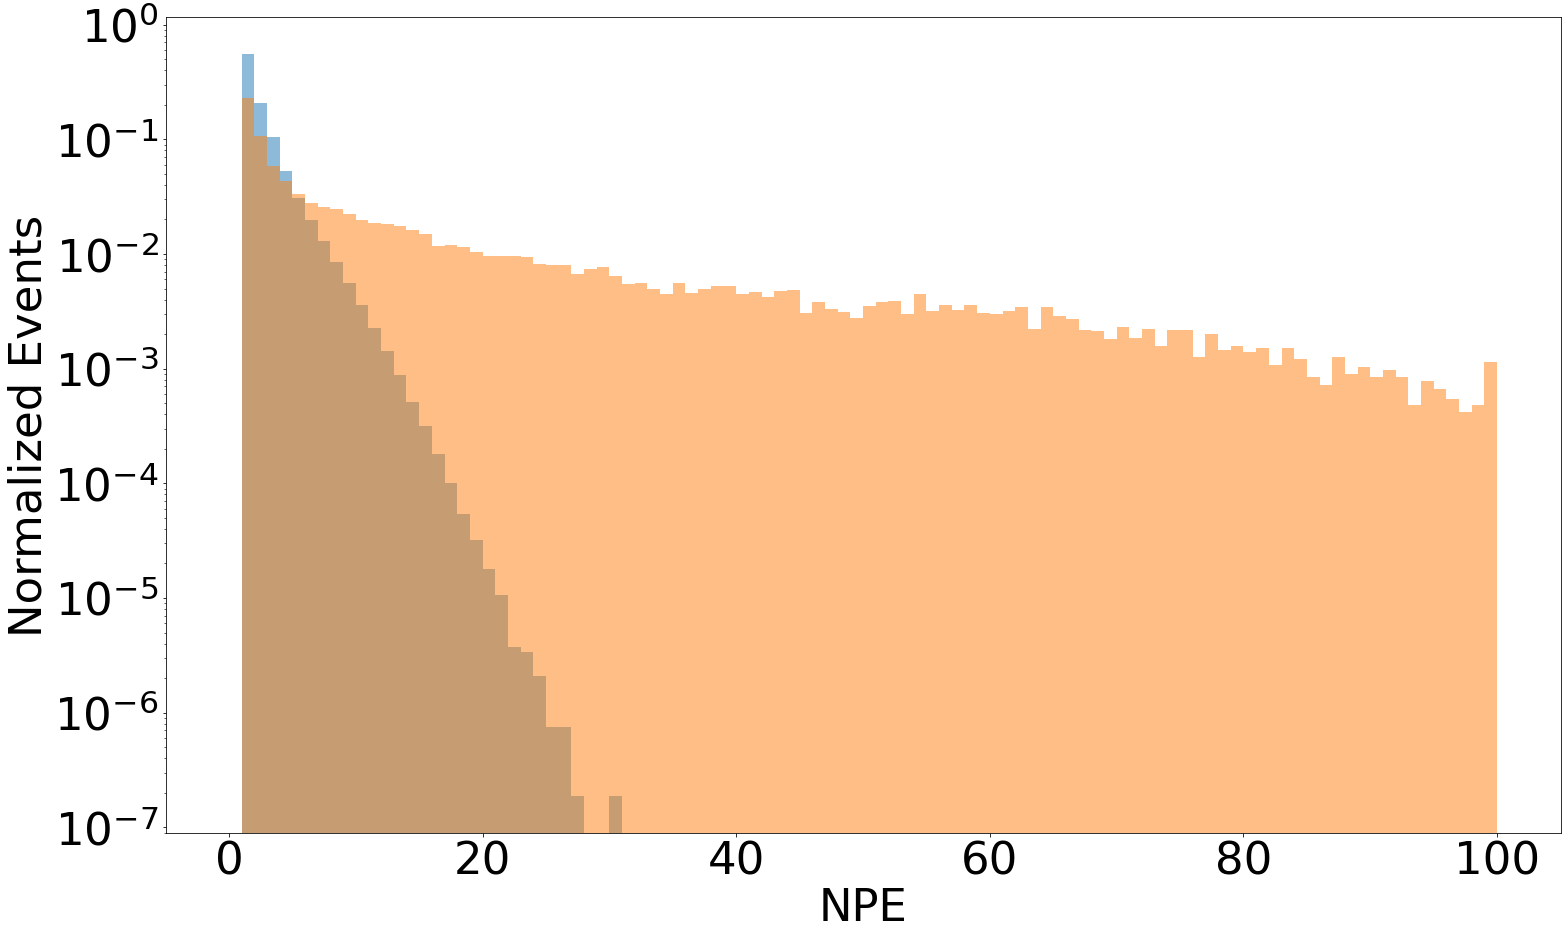

In [26]:
plt.hist(dfall1ar39.pedetected, bins=np.linspace(0, 100, 101), alpha=0.50, density=True, label="Ar39")
plt.hist(dfallar41.pedetected, bins=np.linspace(0, 100, 101), alpha=0.50, density=True, label="Ar41")
plt.ylabel("Normalized Events")
plt.xlabel("NPE")
plt.yscale("log")
plt.show()

# cut data

In [29]:
dfcutar39 = dfall1ar39[(dfall1ar39.pedetected>=5) & (dfall1ar39.pedetected<=50)]
dfcutar41 = dfallar41[(dfallar41.pedetected>=5) & (dfallar41.pedetected<=50)]

print("[Info] Ar39: original events: {}, events in [5,50]: {}".format(len(dfall1ar39), len(dfcutar39)))
print("[Info] Ar41: original events: {}, events in [5,50]: {}".format(len(dfallar41), len(dfcutar41)))

[Info] Ar39: original events: 5303515, events in [5,50]: 461921
[Info] Ar41: original events: 16681, events in [5,50]: 7692


# features

In [27]:
# Create Features
def pe_detected(row):
    return np.sum(row.to_numpy())

def nr_active_slices(row):
    return np.nonzero(row.to_numpy())[0].shape[0]

def mean_npe(row):
    return np.mean(row.to_numpy())

def mean_npe_active(row):
    rownp = row.to_numpy()
    rownonzero = np.nonzero(rownp)[0]
    return np.mean(rownp[rownonzero]) if rownonzero.shape[0]>0 else -1

def std_npe(row):
    return np.std(row.to_numpy())

def std_npe_active(row):
    rownp = row.to_numpy()
    rownonzero = np.nonzero(rownp)[0]
    return np.std(rownp[rownonzero]) if rownonzero.shape[0]>0 else -1

def range_detections(row):
    rownp = row.to_numpy()
    rownonzero = np.nonzero(rownp)[0]
    return rownonzero[-1] - rownonzero[0] + 1 if rownonzero.shape[0]>0 else -1

def spatial_var(row):
    rownp = row.to_numpy()
    ids = np.repeat(np.argwhere(rownp>0), rownp[rownp>0])
    return np.var(ids) if ids.shape[0]>0 else -1

def spatial_std(row):
    rownp = row.to_numpy()
    ids = np.repeat(np.argwhere(rownp>0), rownp[rownp>0])
    return np.std(ids) if ids.shape[0]>0 else -1

def compute_features(row):
    rownp = row.to_numpy()
    return [np.sum(rownp),                        # NPE
            np.nonzero(rownp)[0].shape[0],        # NActiveSlices
            np.mean(rownp),                       # Mean NPE
            np.std(rownp),                        # Std NPE
            np.nonzero(rownp)[0][-1] - np.nonzero(rownp)[0][0] + 1,    # Range
            np.var(np.repeat(np.argwhere(rownp>0), rownp[rownp>0])),   # Var
            np.std(np.repeat(np.argwhere(rownp>0), rownp[rownp>0]))]   # Var   

In [30]:
ar39_feat = pd.DataFrame()
inner_slices, outer_slices = 12, 20
ar39_feat["PEDetected_inner"] = dfcutar39.iloc[:, 3:3+inner_slices].apply(lambda row: pe_detected(row), axis=1)
ar39_feat["NActiveSlices_inner"] = dfcutar39.iloc[:, 3:3+inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
ar39_feat["SpatialRange_inner"] = dfcutar39.iloc[:, 3:3+inner_slices].apply(lambda row: range_detections(row), axis=1)
ar39_feat["SpatialStd_inner"] = dfcutar39.iloc[:, 3:3+inner_slices].apply(lambda row: spatial_std(row), axis=1)
ar39_feat["PEDetected_outer"] = dfcutar39.iloc[:, 3+inner_slices:3+inner_slices+outer_slices].apply(lambda row: pe_detected(row), axis=1)
ar39_feat["NActiveSlices_outer"] = dfcutar39.iloc[:, 3+inner_slices:3+inner_slices+outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
ar39_feat["SpatialRange_outer"] = dfcutar39.iloc[:, 3+inner_slices:3+inner_slices+outer_slices].apply(lambda row: range_detections(row), axis=1)
ar39_feat["SpatialStd_outer"] = dfcutar39.iloc[:, 3+inner_slices:3+inner_slices+outer_slices].apply(lambda row: spatial_std(row), axis=1)

In [31]:
ar41_feat = pd.DataFrame()
inner_slices, outer_slices = 12, 20
ar41_feat["PEDetected_inner"] = dfcutar41.iloc[:, 3:3+inner_slices].apply(lambda row: pe_detected(row), axis=1)
ar41_feat["NActiveSlices_inner"] = dfcutar41.iloc[:, 3:3+inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
ar41_feat["SpatialRange_inner"] = dfcutar41.iloc[:, 3:3+inner_slices].apply(lambda row: range_detections(row), axis=1)
ar41_feat["SpatialStd_inner"] = dfcutar41.iloc[:, 3:3+inner_slices].apply(lambda row: spatial_std(row), axis=1)
ar41_feat["PEDetected_outer"] = dfcutar41.iloc[:, 3+inner_slices:3+inner_slices+outer_slices].apply(lambda row: pe_detected(row), axis=1)
ar41_feat["NActiveSlices_outer"] = dfcutar41.iloc[:, 3+inner_slices:3+inner_slices+outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
ar41_feat["SpatialRange_outer"] = dfcutar41.iloc[:, 3+inner_slices:3+inner_slices+outer_slices].apply(lambda row: range_detections(row), axis=1)
ar41_feat["SpatialStd_outer"] = dfcutar41.iloc[:, 3+inner_slices:3+inner_slices+outer_slices].apply(lambda row: spatial_std(row), axis=1)

# plot PE detected

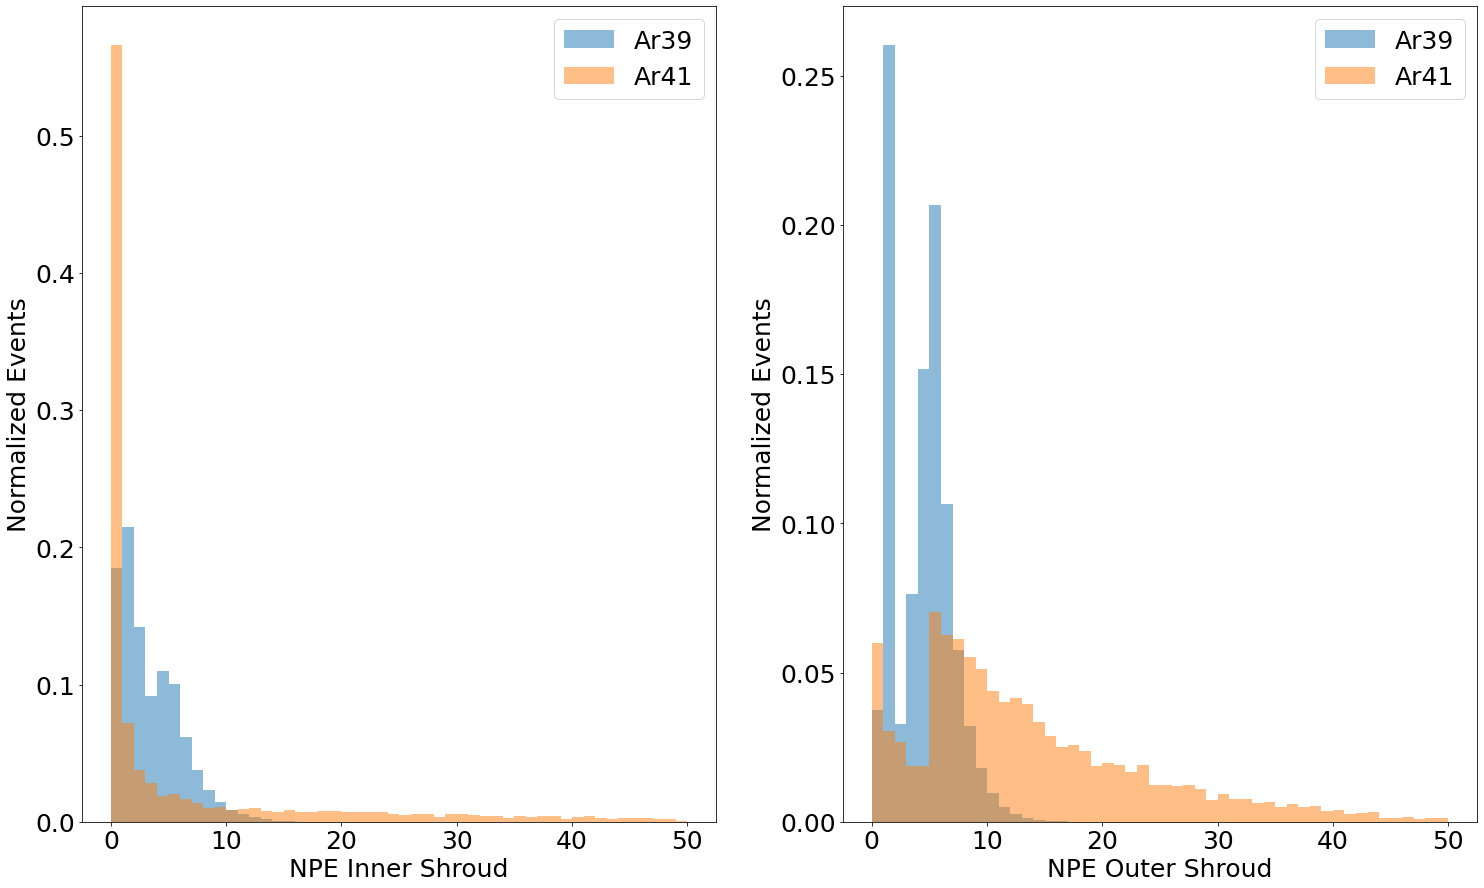

In [48]:
bins = np.linspace(0, 50, 51)
plt.subplot(1, 2, 1)
plt.hist(ar39_feat.PEDetected_inner, bins=bins, label="Ar39", density=True, alpha=.50)
plt.hist(ar41_feat.PEDetected_inner, bins=bins, label="Ar41", density=True, alpha=.50)
plt.xlabel("NPE Inner Shroud")
plt.ylabel("Normalized Events")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(ar39_feat.PEDetected_outer, bins=bins, label="Ar39", density=True, alpha=.50)
plt.hist(ar41_feat.PEDetected_outer, bins=bins, label="Ar41", density=True, alpha=.50)
plt.xlabel("NPE Outer Shroud")
plt.ylabel("Normalized Events")
plt.legend()

plt.show()

# plot Nr Active Slices

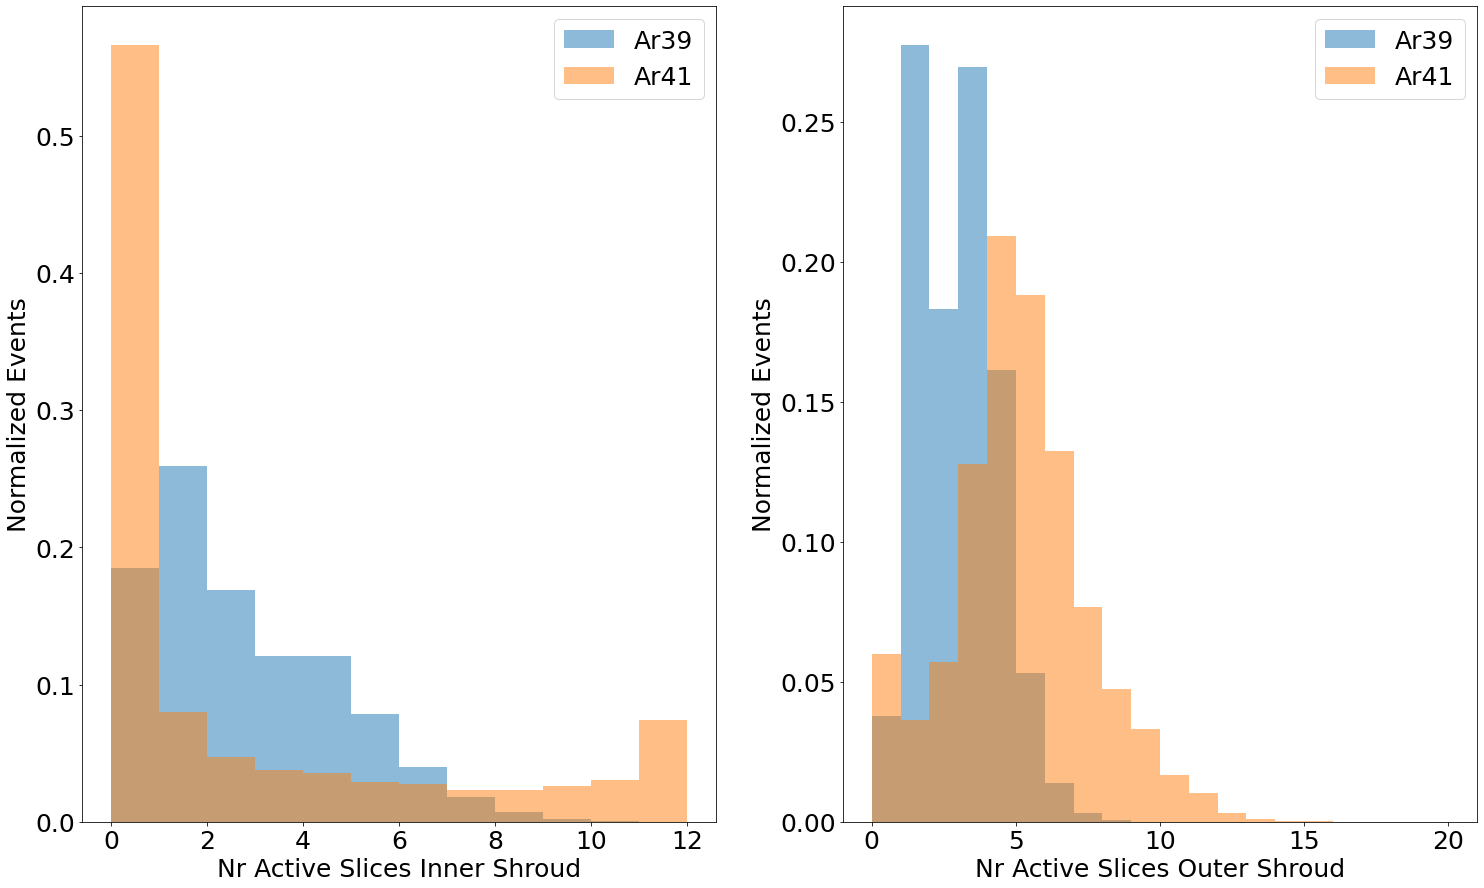

In [49]:
bins = np.linspace(0, 12, 13)
plt.subplot(1, 2, 1)
plt.hist(ar39_feat.NActiveSlices_inner, bins=bins, label="Ar39", density=True, alpha=.50)
plt.hist(ar41_feat.NActiveSlices_inner, bins=bins, label="Ar41", density=True, alpha=.50)
plt.xlabel("Nr Active Slices Inner Shroud")
plt.ylabel("Normalized Events")
plt.legend()

plt.subplot(1, 2, 2)
bins = np.linspace(0, 20, 21)
plt.hist(ar39_feat.NActiveSlices_outer, bins=bins, label="Ar39", density=True, alpha=.50)
plt.hist(ar41_feat.NActiveSlices_outer, bins=bins, label="Ar41", density=True, alpha=.50)
plt.xlabel("Nr Active Slices Outer Shroud")
plt.ylabel("Normalized Events")
plt.legend()

plt.show()

# plot spatial range

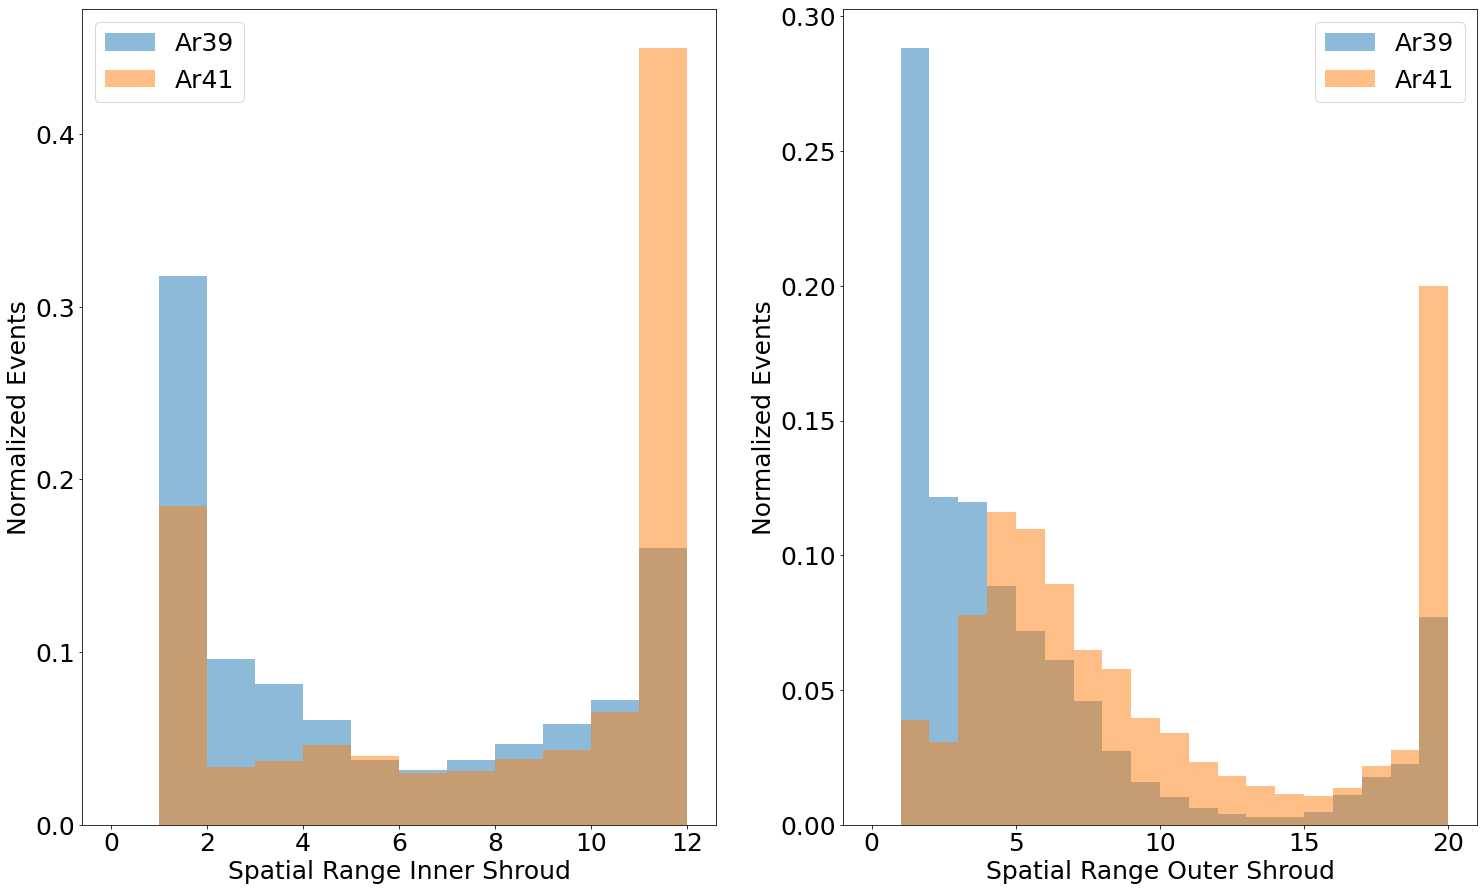

In [50]:
bins = np.linspace(0, 12, 13)
plt.subplot(1, 2, 1)
plt.hist(ar39_feat.SpatialRange_inner, bins=bins, label="Ar39", density=True, alpha=.50)
plt.hist(ar41_feat.SpatialRange_inner, bins=bins, label="Ar41", density=True, alpha=.50)
plt.xlabel("Spatial Range Inner Shroud")
plt.ylabel("Normalized Events")
plt.legend()

plt.subplot(1, 2, 2)
bins = np.linspace(0, 20, 21)
plt.hist(ar39_feat.SpatialRange_outer, bins=bins, label="Ar39", density=True, alpha=.50)
plt.hist(ar41_feat.SpatialRange_outer, bins=bins, label="Ar41", density=True, alpha=.50)
plt.xlabel("Spatial Range Outer Shroud")
plt.ylabel("Normalized Events")
plt.legend()

plt.show()

# plot spatial std dev

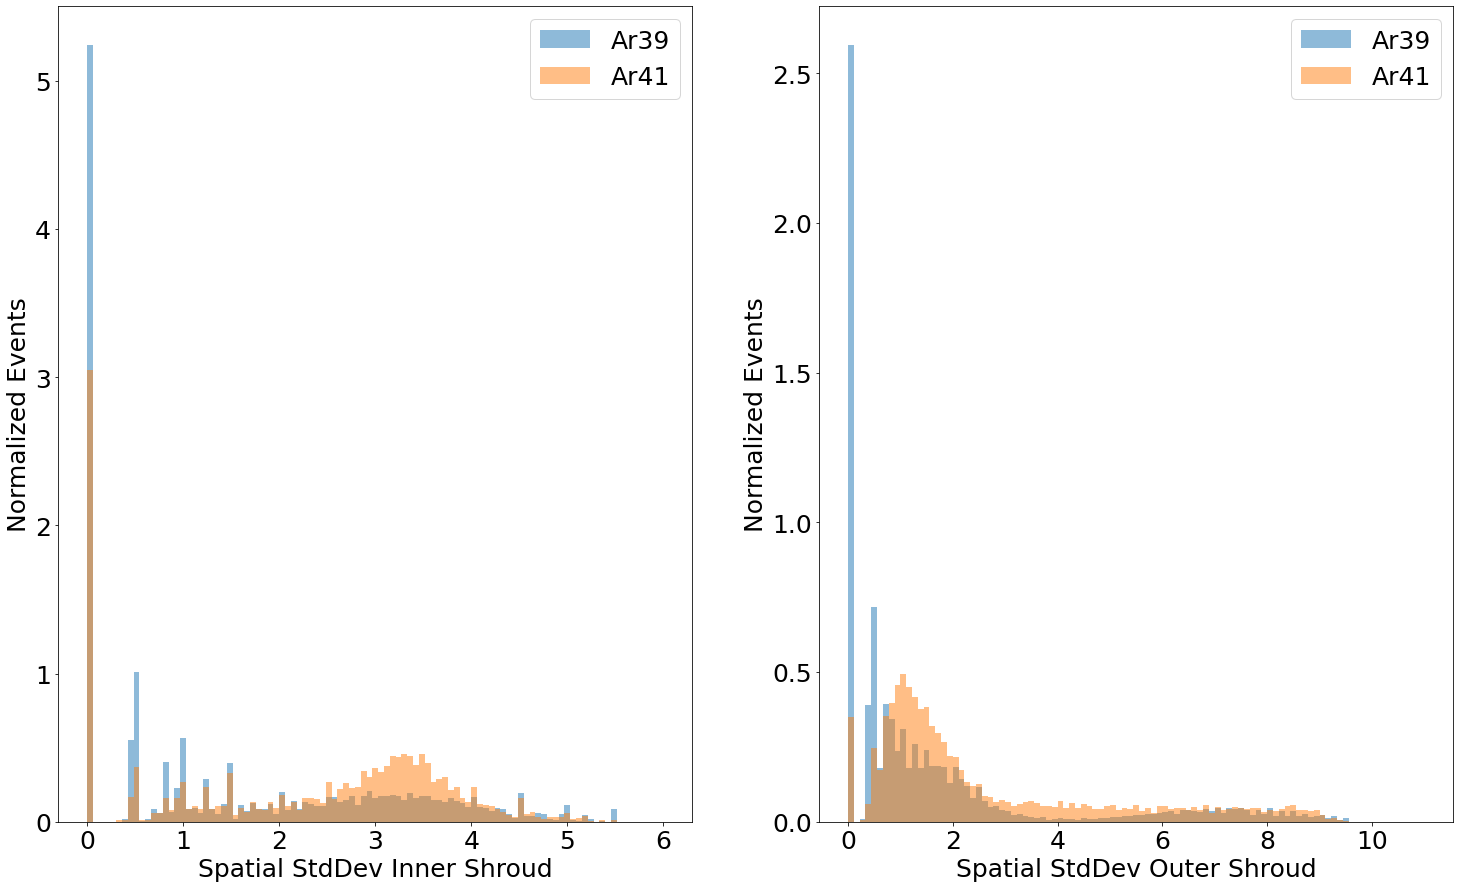

In [51]:
bins = np.linspace(0, 6, 100)
plt.subplot(1, 2, 1)
plt.hist(ar39_feat.SpatialStd_inner, bins=bins, label="Ar39", density=True, alpha=.50)
plt.hist(ar41_feat.SpatialStd_inner, bins=bins, label="Ar41", density=True, alpha=.50)
plt.xlabel("Spatial StdDev Inner Shroud")
plt.ylabel("Normalized Events")
plt.legend()

plt.subplot(1, 2, 2)
bins = np.linspace(0, 11, 100)
plt.hist(ar39_feat.SpatialStd_outer, bins=bins, label="Ar39", density=True, alpha=.50)
plt.hist(ar41_feat.SpatialStd_outer, bins=bins, label="Ar41", density=True, alpha=.50)
plt.xlabel("Spatial StdDev Outer Shroud")
plt.ylabel("Normalized Events")
plt.legend()

plt.show()